# Gramener Data Science Entry Level Position Use Case 1

In [108]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [109]:
datapath = './'
filename = 'nas-pupil-marks.csv'
Data = pd.read_csv(datapath+filename)
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185348 entries, 0 to 185347
Data columns (total 64 columns):
STUID                     185348 non-null int64
State                     185348 non-null object
District                  185348 non-null int64
Gender                    185348 non-null int64
Age                       185348 non-null int64
Category                  185348 non-null int64
Same language             185348 non-null int64
Siblings                  185348 non-null int64
Handicap                  185348 non-null int64
Father edu                185348 non-null int64
Mother edu                185348 non-null int64
Father occupation         185348 non-null int64
Mother occupation         185348 non-null int64
Below poverty             185348 non-null int64
Use calculator            185348 non-null int64
Use computer              166186 non-null object
Use Internet              185348 non-null int64
Use dictionary            185348 non-null int64
Read other books       

Walking into this, we have 3 questions that we hope to answer eventually - 
1. What influences student performance the most?
2. How do girls and boys perform across states?
3. Do students from South India really excel at Math and Science

## Data Cleaning

Before we delve into this, a few issues seem to be cropping up - so let's try to clean the dataset up a little. 
First we should check for nulls - if present, we should attempt to drop them. 

In [110]:
NullsDropped = Data.dropna(axis=0,how='all',inplace=False)
NullsDropped.shape

(185348, 64)

Immediately, there are no rows such that all values are null. The rows which have the most nulls are our metrics of performance, the maths, science, social science and reading scores. This presents a major problem as we can't easily use a statistical measure such as mean of their respective columns to fill the null values, as this might potentially taint our data as we look for correlations. Dropping all the rows with nulls would also not be ideal, as we'd reduce our current number of data points by ~96% as is evidenced below. 

In [111]:
NullsDropped = Data.dropna(axis=0,how='any',inplace=False)
NullsDropped.shape

(8044, 64)

This is problematic, in that dropping rows which have any nulls reduces the number of rows so drastically. 
we're literally left with 4% of our initial dataset. 
One thing that might potentially help is to split our data frame into one frame for each of our metrics, so have a seperate maths column, a separate science column etc. then drop the nulls, this would let us potentially retain close to 40% of our dataset. 
Moreover, we also have 0 levels in our dataset for columns that shouldn't be given 0 levels according to the labels csv file. We also need find a way to deal with those. 

In [112]:
Maths = Data.drop(['Reading %','Science %','Social %'],axis=1)

Similarly, we create a dataset for each metric of performance

In [113]:
Reading = Data.drop(['Maths %','Science %','Social %'],axis=1)
Science = Data.drop(['Maths %','Reading %','Social %'],axis=1)
Social = Data.drop(['Maths %','Reading %','Science %'],axis=1)
Maths_and_Science = Data.drop(['Reading %','Social %'],axis=1)

In [114]:
filename = 'nas-labels.csv'
labels = pd.read_csv(datapath+filename)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
Column    241 non-null object
Name      241 non-null object
Level     241 non-null object
Rename    241 non-null object
dtypes: object(4)
memory usage: 7.6+ KB


In [115]:
zero_allowed = pd.DataFrame(labels.loc[labels['Level'].astype(str) == '0']) 
#Slightly janky, but I didn't want to drop the states and can't convert characters to base 10 ints implicitly.
zero_allowed = zero_allowed['Column'].tolist()
#Gives me the list of the columns which shouldn't have zeroes. 
def remove_zeroes(df):
    '''Helper function that first removes nulls and then removes 0's from rows that shouldn't have zeroes.'''
    df.dropna(axis=0,how='any',inplace=True)
    zero_not_allowed = [item for item in df.columns.values.tolist() if item not in zero_allowed]
    df = df.replace(0,np.nan) 
    #Since the dropna function has a subset parameter, casting 0's to  
    df.dropna(axis =0, how='any',inplace=True,subset = zero_not_allowed)
    df.fillna(value=0,inplace=True)
    
    #Convert object types to categories and categories to cat codes. 
    objects = df.select_dtypes(include=['O']).columns.tolist()
    for col in objects:
        df[col] = df[col].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

In [116]:
Maths=remove_zeroes(Maths)
Science=remove_zeroes(Science)
Social=remove_zeroes(Social)
Reading=remove_zeroes(Reading)
Maths_and_Science=remove_zeroes(Maths_and_Science)
NullsDropped=remove_zeroes(NullsDropped)


/home/karmanya/anaconda3/envs/MLIntel/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finally we should take the average of the performance metrics for the frames with multiple metrics

In [118]:
## Maths and Science
Maths_and_Science['Avg %'] = (Maths_and_Science['Maths %']+Maths_and_Science['Science %'])/2
Maths_and_Science.drop(['Maths %','Science %'],axis=1,inplace=True)

NullsDropped['Avg %'] = (NullsDropped['Maths %']+NullsDropped['Science %']+NullsDropped['Social %']+NullsDropped['Reading %'])/4
NullsDropped.drop(['Maths %','Science %','Social %','Reading %'],axis=1,inplace=True)

In [119]:
Science.isnull().values.any()

False

In [120]:
Maths.describe()

,STUID,State,District,Gender,Age,Category,Same language,Siblings,Handicap,Father edu,...,Observe experiments,Conduct experiments,Solve science problems,Express science views,Watch TV,Read magazine,Read a book,Play games,Help in household,Maths %
count,5.054200e+04,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,...,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000,50542.000000
mean,2.714830e+10,15.465989,5.114222,1.520894,3.644870,2.654901,1.305647,3.465039,1.895374,2.213090,...,2.646769,2.082941,2.426833,2.349828,3.556587,3.168850,3.096019,3.445333,3.511456,32.903478
std,9.808741e+09,9.460908,4.030791,0.499568,0.946113,1.211942,0.531592,1.209956,0.380640,1.222056,...,0.692864,0.930929,0.813011,0.822457,0.798879,1.017827,0.922589,0.882576,1.012895,15.862777
min,1.101100e+10,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.670000
25%,1.808118e+10,7.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,2.000000,1.000000,...,3.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,22.030000
50%,2.607110e+10,15.000000,4.000000,2.000000,4.000000,3.000000,1.000000,3.000000,2.000000,2.000000,...,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,4.000000,28.810000
75%,3.601103e+10,24.000000,7.000000,2.000000,4.000000,4.000000,2.000000,5.000000,2.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,38.980000
max,4.502103e+10,32.000000,28.000000,2.000000,6.000000,4.000000,2.000000,5.000000,2.000000,5.000000,...,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,100.000000


Ok so now the datasets are relatively cleaned both nulls and excessive zeroes in columns that shouldn't be zeroes have been dropped. It's caused a large reduction in samples, Optimistically, each of our targets now have 30% of the total number of samples that we originally had. I could potentially increase this by replacing the non target colums with mean values or other statistical measure, but I'm a little worried about tainting my correlation measures. 


## Exploring Student Performance

Checking first for linear correlations, we simply draw a correlation matrix. Since plotting each of the 60 odd features in the matrix would make a fairly illegible plot, I've written a function that plots the top k correlations instead. 

In [128]:
def correlation_matrix(df,target):
    '''Helper function for correlation matrix'''
    k = 10 #number of variables for heatmap
    corrmat = df.corr()
    cols = corrmat.nlargest(k, target)[target].index
    cm = np.corrcoef(df[cols].values.T)
    fig, ax = plt.subplots()
    fig.set_size_inches(10,8)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,ax=ax)
    plt.show()



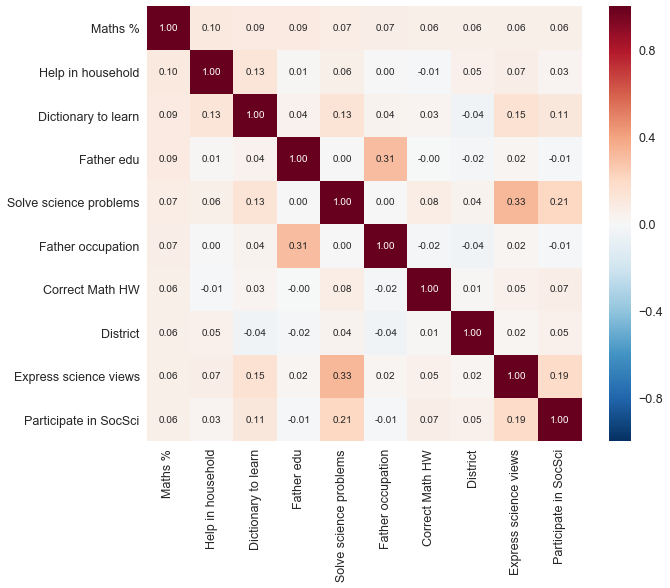

In [129]:
correlation_matrix(Maths,'Maths %')

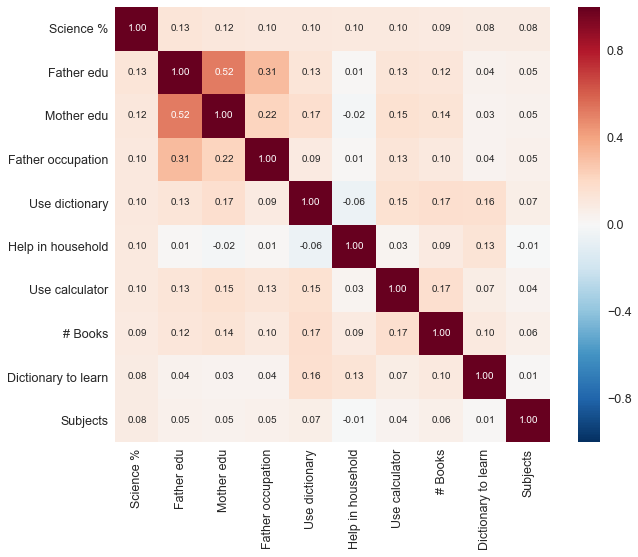

In [130]:
correlation_matrix(Science,'Science %')

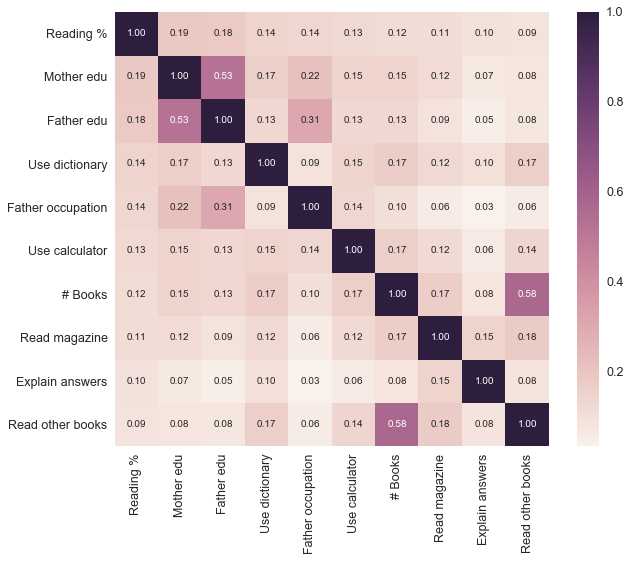

In [131]:
correlation_matrix(Reading,'Reading %')

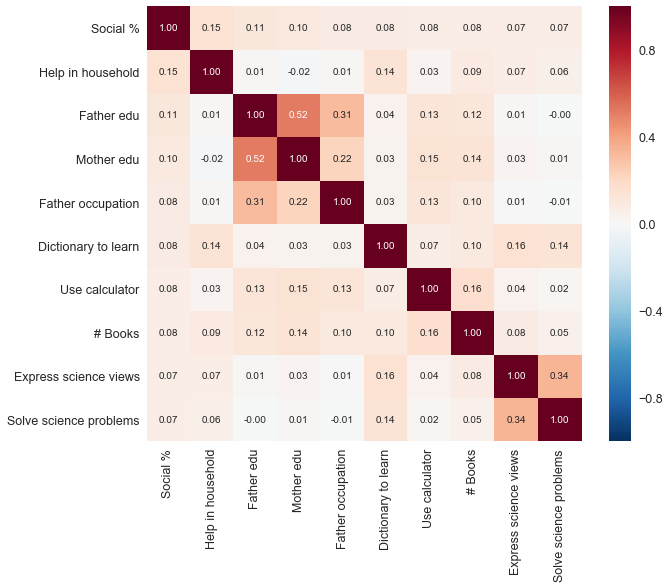

In [151]:
correlation_matrix(Social,'Social %')

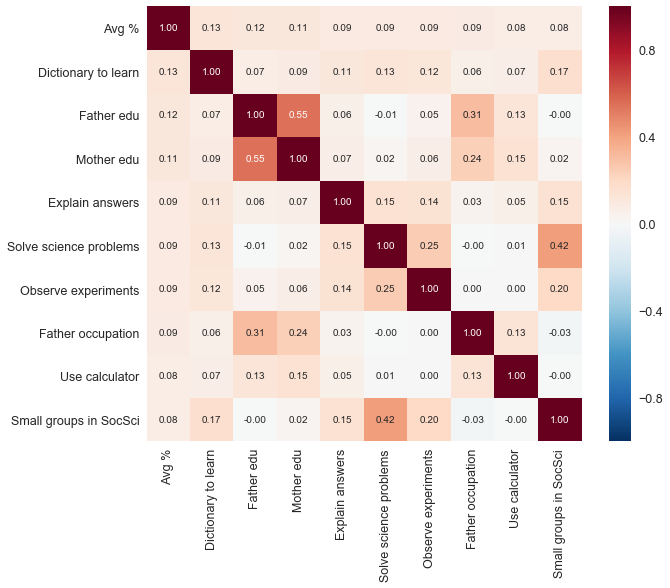

In [132]:
correlation_matrix(Maths_and_Science,'Avg %')

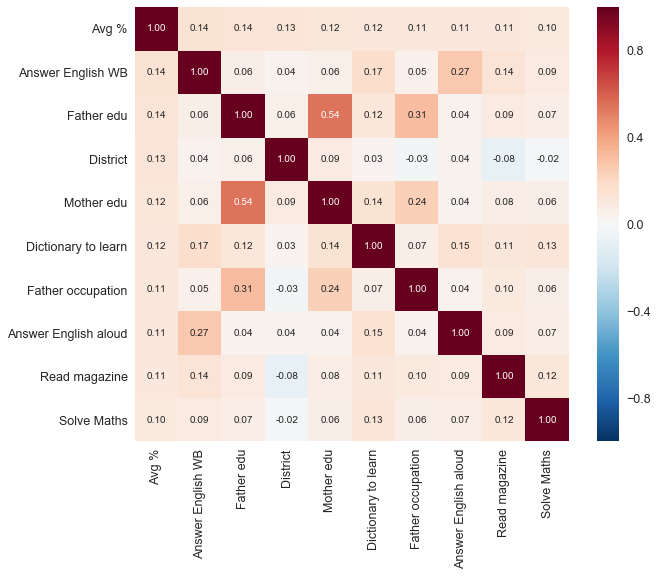

In [133]:
correlation_matrix(NullsDropped,'Avg %')

In terms of a linear correlation of features, The parents of the child being educated seems to be very important across the board. Other fairly intuitive things seem to be important such as having a dictionary, readings etc. 
The fact that having a calculator is fairly important even in reading, probably means that there's a subset of people that are high scorers across the board - not just in maths and science but also in reading and social sciences. That's worth looking into. Finally we should also check for non linear correlations between the features.

In [ ]:
#TODO ADD RANDOM FORESTS REGRESSOR FOR NON LINEAR CORRELATION and CHECK FOR TOPPERS ACROSS ALL FIELDS

## Girls vs Boys Across States
So, lets start by a simple metric, looking at the average of scores of boys and girls overall

In [148]:
def split_girl_boy(df,target):
    boys=df.loc[df['Gender']==1].groupby('State',as_index=False)[target].mean()
    girls=df.loc[df['Gender']==2].groupby('State',as_index=False)[target].mean()
    return (boys,girls)

In [152]:
(boys_maths_score,girls_maths_score) = split_girl_boy(Maths,'Maths %')
(boys_science_score,girls_science_score) = split_girl_boy(Science,'Science %')
(boys_reading_score,girls_reading_score) = split_girl_boy(Reading,'Reading %')
(boys_social_score,girls_social_score) = split_girl_boy(Social,'Social %')
(boys_mathsandscience_score,girls_mathsandscience_score) = split_girl_boy(Maths_and_Science,'Avg %')
(boys_overall_score,girls_overall_score) = split_girl_boy(NullsDropped,'Avg %')

,State,Science %
0,0,41.655367
1,1,32.790066
2,2,39.744668
3,3,37.480513
4,4,35.291153
5,5,36.480265
6,6,49.985000
7,7,33.521005
8,8,46.618870
9,9,42.444022
